In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import keras.utils as utils
from sklearn import metrics
%matplotlib inline 

Using TensorFlow backend.
C:\Users\Guus\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Guus\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Guus\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Guus\Anaconda3\envs\PythonGPU

In [2]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

## Loading Data

In [3]:
filedir = ".\\data\\"
activities = ['cycling', 'driving', 'jogging', 'sleeping', 'walking']
epoch_length = 360

In [4]:
pickle_in = open(filedir+"data\\data.pickle","rb")
data_dict = pickle.load(pickle_in)
pickle_in.close()

In [5]:
X = data_dict["cnn_array"]

In [6]:
y = []
for item in data_dict["label"]:
    #value = 0
    if item == activities[0]:
        y.append(0)
    elif item == activities[1]:
        y.append(1)
    elif item == activities[2]:
        y.append(2)
    elif item == activities[3]:
        y.append(3)
    elif item == activities[4]:
        y.append(4)

## Train / Test Split 60/20/20

In [7]:
test_size = int(int(X.shape[0] * 0.2) / len(set(y))) * len(set(y))

In [8]:
from sklearn.model_selection import train_test_split
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=test_size, random_state=4091988, stratify=y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=test_size, random_state=4091988, stratify=y_data)

In [10]:
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
y_val = utils.to_categorical(y_val)

## Novel CNN

In [11]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [12]:
verbose, epochs, batch_size = 1, 20, 32

In [13]:
## Model is from https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [14]:
model.fit(X_train, y_train, epochs = epochs, 
          validation_data = (X_val, y_val), 
          batch_size = batch_size, verbose=verbose)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4890 samples, validate on 1625 samples
Epoch 1/20
4890/4890 [==============================] - 3s 541us/step - loss: 0.4950 - acc: 0.8321 - val_loss: 0.3500 - val_acc: 0.8954
Epoch 2/20
4890/4890 [==============================] - 1s 107us/step - loss: 0.3044 - acc: 0.9031 - val_loss: 0.3493 - val_acc: 0.9034
Epoch 3/20
4890/4890 [==============================] - 1s 106us/step - loss: 0.2618 - acc: 0.9112 - val_loss: 0.3148 - val_acc: 0.9071
Epoch 4/20
4890/4890 [==============================] - 1s 107us/step - loss: 0.2404 - acc: 0.9211 - val_loss: 0.2894 - val_acc: 0.9114
Epoch 5/20
4890/4890 [==============================] - 1s 107us/step - loss: 0.2178 - acc: 0.9274 - val_loss: 0.2955 - val_acc: 0.8942
Epoch 6/20
4890/4890 [==============================] - 1s 107us/step - loss: 0.2038 - acc: 0.9309 - val_loss: 0.2963 - val_acc: 0.9157
Epoch 7/20
4890/4890 [===================

In [15]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
accuracy

0.9101538457503685

In [16]:
results = open("accuracy_base60.txt","w")
results.write(str(accuracy))
results.close()

In [17]:
y_pred = model.predict_classes(X_test)

In [18]:
print(metrics.classification_report(np.argmax(y_test,axis=1), y_pred, target_names = activities, digits = 4))

              precision    recall  f1-score   support

     cycling     0.9183    0.8646    0.8906       325
     driving     0.8011    0.8800    0.8387       325
     jogging     0.9877    0.9908    0.9892       325
    sleeping     0.9742    0.9292    0.9512       325
     walking     0.8834    0.8862    0.8848       325

    accuracy                         0.9102      1625
   macro avg     0.9130    0.9102    0.9109      1625
weighted avg     0.9130    0.9102    0.9109      1625



In [19]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(np.argmax(y_test,axis=1), y_pred))

Confusion matrix:
[[281  28   1   3  12]
 [ 17 286   1   2  19]
 [  1   0 322   0   2]
 [  4  14   0 302   5]
 [  3  29   2   3 288]]


---

## Novel + Tuning Parameters

In [20]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [22]:
verbose, epochs, batch_size = 1, 1000, 64

In [23]:
## Model is from https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model_novel = Sequential()
model_novel.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model_novel.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_novel.add(Dropout(0.5))
model_novel.add(MaxPooling1D(pool_size=2))
model_novel.add(Flatten())
model_novel.add(Dense(100, activation='relu'))
model_novel.add(Dense(n_outputs, activation='softmax'))
model_novel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=50)

mc = ModelCheckpoint('.\\data\\data\\best_model_novel_60.h5', monitor='val_acc', mode='max', verbose=verbose,
                     save_best_only=True)

history_novel = model_novel.fit(X_train, y_train, epochs = epochs, 
          validation_data = (X_val, y_val), 
          batch_size = batch_size, verbose=verbose,
                   callbacks=[es, mc])

Train on 4890 samples, validate on 1625 samples
Epoch 1/1000
4890/4890 [==============================] - 1s 133us/step - loss: 0.5289 - acc: 0.8223 - val_loss: 0.3922 - val_acc: 0.8775

Epoch 00001: val_acc improved from -inf to 0.87754, saving model to .\data\data\best_model_novel_60.h5
Epoch 2/1000
4890/4890 [==============================] - 0s 66us/step - loss: 0.3044 - acc: 0.9022 - val_loss: 0.3371 - val_acc: 0.8960

Epoch 00002: val_acc improved from 0.87754 to 0.89600, saving model to .\data\data\best_model_novel_60.h5
Epoch 3/1000
4890/4890 [==============================] - 0s 67us/step - loss: 0.2629 - acc: 0.9139 - val_loss: 0.3648 - val_acc: 0.8849

Epoch 00003: val_acc did not improve from 0.89600
Epoch 4/1000
4890/4890 [==============================] - 0s 67us/step - loss: 0.2372 - acc: 0.9196 - val_loss: 0.2937 - val_acc: 0.9022

Epoch 00004: val_acc improved from 0.89600 to 0.90215, saving model to .\data\data\best_model_novel_60.h5
Epoch 5/1000
4890/4890 [==========

4890/4890 [==============================] - 0s 67us/step - loss: 0.0480 - acc: 0.9838 - val_loss: 0.3998 - val_acc: 0.9046

Epoch 00042: val_acc did not improve from 0.91938
Epoch 43/1000
4890/4890 [==============================] - 0s 68us/step - loss: 0.0392 - acc: 0.9863 - val_loss: 0.3736 - val_acc: 0.9108

Epoch 00043: val_acc did not improve from 0.91938
Epoch 44/1000
4890/4890 [==============================] - 0s 68us/step - loss: 0.0468 - acc: 0.9857 - val_loss: 0.3961 - val_acc: 0.9126

Epoch 00044: val_acc did not improve from 0.91938
Epoch 45/1000
4890/4890 [==============================] - 0s 66us/step - loss: 0.0553 - acc: 0.9826 - val_loss: 0.3589 - val_acc: 0.9188

Epoch 00045: val_acc did not improve from 0.91938
Epoch 46/1000
4890/4890 [==============================] - 0s 66us/step - loss: 0.0407 - acc: 0.9863 - val_loss: 0.3804 - val_acc: 0.9071

Epoch 00046: val_acc did not improve from 0.91938
Epoch 47/1000
4890/4890 [==============================] - 0s 67us/st

In [25]:
saved_model_novel = load_model('.\\data\\data\\best_model_novel_60.h5')

In [26]:
y_pred_novel = saved_model_novel.predict_classes(X_test)

In [27]:
_, accuracy_novel = saved_model_novel.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy_novel

1625/1625 [==============================] - 0s 46us/sample - loss: 0.5094 - acc: 0.9194


0.9193846

In [28]:
print(metrics.classification_report(np.argmax(y_test,axis=1), y_pred_novel, target_names = activities, digits = 4))

              precision    recall  f1-score   support

     cycling     0.8970    0.9108    0.9038       325
     driving     0.8338    0.8646    0.8489       325
     jogging     0.9789    0.9969    0.9878       325
    sleeping     0.9577    0.9754    0.9665       325
     walking     0.9324    0.8492    0.8889       325

    accuracy                         0.9194      1625
   macro avg     0.9200    0.9194    0.9192      1625
weighted avg     0.9200    0.9194    0.9192      1625



In [29]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(np.argmax(y_test,axis=1), y_pred_novel))

Confusion matrix:
[[296  19   2   2   6]
 [ 20 281   1   9  14]
 [  1   0 324   0   0]
 [  2   6   0 317   0]
 [ 11  31   4   3 276]]


In [30]:
results = open("accuracy_novel60.txt","w")
results.write(str(accuracy_novel))
results.close()

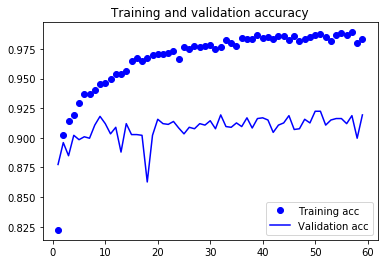

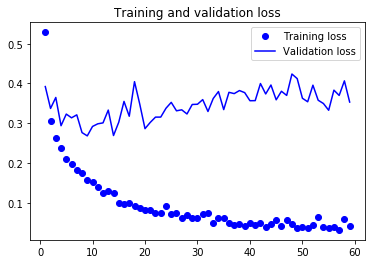

In [31]:
acc = history_novel.history['acc']

val_acc = history_novel.history['val_acc']
loss = history_novel.history['loss']
val_loss = history_novel.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig('novel60_graph'+str(1)+'.png')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('novel60_graph'+str(2)+'.png')
plt.legend()

plt.show()

---

## ResNet CNN Architecture

In [32]:
import keras as keras
import tensorflow as tf

In [33]:
verbose, epochs, batch_size = 1, 1000, 64

In [34]:
## Architecture is from https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/resnet.py
n_feature_maps = 64

input_layer = keras.layers.Input(shape = (n_timesteps,n_features))

# BLOCK 1

conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

output_layer = keras.layers.Dense(n_outputs, activation='softmax')(gap_layer)

model_resnet = keras.models.Model(inputs=input_layer, outputs=output_layer)

model_resnet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=50)

mc = ModelCheckpoint('.\\data\\data\\best_model_resnet_60.h5', monitor='val_acc', mode='max', verbose=verbose,
                     save_best_only=True)

history_resnet = model_resnet.fit(X_train, y_train, epochs = 1000, 
          validation_data = (X_val, y_val), 
          batch_size = batch_size, verbose=verbose,
                   callbacks=[es, mc])

Train on 4890 samples, validate on 1625 samples
Epoch 1/1000
4890/4890 [==============================] - 5s 1ms/step - loss: 0.4172 - acc: 0.8607 - val_loss: 0.3452 - val_acc: 0.8880

Epoch 00001: val_acc improved from -inf to 0.88800, saving model to .\data\data\best_model_resnet_60.h5
Epoch 2/1000
4890/4890 [==============================] - 3s 515us/step - loss: 0.3061 - acc: 0.8980 - val_loss: 0.3052 - val_acc: 0.9046

Epoch 00002: val_acc improved from 0.88800 to 0.90462, saving model to .\data\data\best_model_resnet_60.h5
Epoch 3/1000
4890/4890 [==============================] - 3s 521us/step - loss: 0.2865 - acc: 0.9045 - val_loss: 0.2901 - val_acc: 0.9138

Epoch 00003: val_acc improved from 0.90462 to 0.91385, saving model to .\data\data\best_model_resnet_60.h5
Epoch 4/1000
4890/4890 [==============================] - 3s 539us/step - loss: 0.2870 - acc: 0.8980 - val_loss: 1.1692 - val_acc: 0.6658

Epoch 00004: val_acc did not improve from 0.91385
Epoch 5/1000
4890/4890 [======

4890/4890 [==============================] - 3s 523us/step - loss: 0.1133 - acc: 0.9593 - val_loss: 0.1388 - val_acc: 0.9446

Epoch 00040: val_acc did not improve from 0.94831
Epoch 41/1000
4890/4890 [==============================] - 3s 538us/step - loss: 0.1215 - acc: 0.9562 - val_loss: 0.1529 - val_acc: 0.9428

Epoch 00041: val_acc did not improve from 0.94831
Epoch 42/1000
4890/4890 [==============================] - 3s 526us/step - loss: 0.1037 - acc: 0.9630 - val_loss: 0.1498 - val_acc: 0.9434

Epoch 00042: val_acc did not improve from 0.94831
Epoch 43/1000
4890/4890 [==============================] - 3s 526us/step - loss: 0.1050 - acc: 0.9573 - val_loss: 0.1503 - val_acc: 0.9458

Epoch 00043: val_acc did not improve from 0.94831
Epoch 44/1000
4890/4890 [==============================] - 3s 537us/step - loss: 0.1173 - acc: 0.9542 - val_loss: 0.1633 - val_acc: 0.9354

Epoch 00044: val_acc did not improve from 0.94831
Epoch 45/1000
4890/4890 [==============================] - 3s 53

4890/4890 [==============================] - 3s 525us/step - loss: 0.0590 - acc: 0.9783 - val_loss: 0.1462 - val_acc: 0.9545

Epoch 00081: val_acc did not improve from 0.95754
Epoch 82/1000
4890/4890 [==============================] - 3s 528us/step - loss: 0.0541 - acc: 0.9798 - val_loss: 0.1504 - val_acc: 0.9569

Epoch 00082: val_acc did not improve from 0.95754
Epoch 83/1000
4890/4890 [==============================] - 3s 523us/step - loss: 0.0783 - acc: 0.9726 - val_loss: 0.1659 - val_acc: 0.9502

Epoch 00083: val_acc did not improve from 0.95754
Epoch 84/1000
4890/4890 [==============================] - 3s 526us/step - loss: 0.0579 - acc: 0.9783 - val_loss: 0.1435 - val_acc: 0.9588

Epoch 00084: val_acc improved from 0.95754 to 0.95877, saving model to .\data\data\best_model_resnet_60.h5
Epoch 85/1000
4890/4890 [==============================] - 3s 525us/step - loss: 0.0570 - acc: 0.9793 - val_loss: 0.1456 - val_acc: 0.9545

Epoch 00085: val_acc did not improve from 0.95877
Epoch 8

In [36]:
saved_model_resnet = load_model('.\\data\\data\\best_model_resnet_60.h5')

In [37]:
y_pred_resnet = np.argmax(saved_model_resnet.predict(X_test), axis=1)

In [38]:
_, accuracy_resnet = saved_model_resnet.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy_resnet

1625/1625 [==============================] - 0s 241us/sample - loss: 0.1354 - acc: 0.9557


0.9556923

In [39]:
print(metrics.classification_report(np.argmax(y_test,axis=1), y_pred_resnet, target_names = activities, digits = 4))

              precision    recall  f1-score   support

     cycling     0.9475    0.9446    0.9461       325
     driving     0.9414    0.8892    0.9146       325
     jogging     0.9969    0.9969    0.9969       325
    sleeping     0.9585    0.9938    0.9758       325
     walking     0.9337    0.9538    0.9437       325

    accuracy                         0.9557      1625
   macro avg     0.9556    0.9557    0.9554      1625
weighted avg     0.9556    0.9557    0.9554      1625



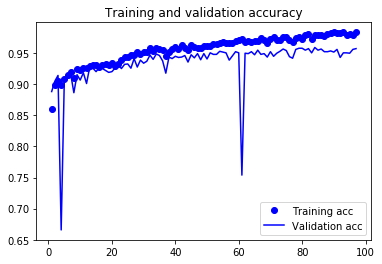

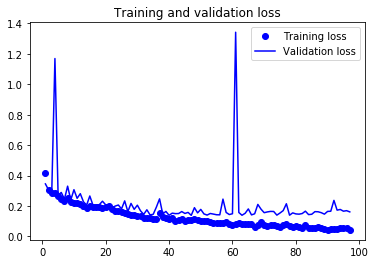

In [40]:
acc = history_resnet.history['acc']

val_acc = history_resnet.history['val_acc']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig('resnet60_graph'+str(1)+'.png')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('resnet60_graph'+str(2)+'.png')
plt.legend()

plt.show()

In [41]:
results = open("accuracy_resnet60.txt","w")
results.write(str(accuracy_resnet))
results.close()

---